### Solución al Modelo Neoclásico de Crecimiento Con gobierno y distorsión de impuestos usando el Shooting Algorithm


solución del modelo


In [7]:
# Paquetes necesarios
using NLsolve, Plots

### Estado Estacionario (Senda de Crecimiento Balanceado)

In [2]:
# Parámetros
α = 0.33
β = 0.98
σ = 1.5
δ = 0.04
tauY = 0.08
tauC = 0.03

gA = 1 + 0.03
gL = 1 + 0.01
params = (α, β, σ, δ, tauY, tauC, gA, gL);

In [4]:
# Hallamos el estado estacionario del modelo
# F(x, params) =0 x=(x1,x2) vector
function sistema_ee(x,p)
    α, β, σ, δ, tauY, tauC, gA, gL = p
        
    k = x[1]
    c = x[2]
    
    fee = zeros(2)
    
    fee[1] = 1 - β*(gA^(-σ))*(α*(1-tauY)*k^(α-1)+1-δ)
    fee[2] = (1-tauY)*(k^α) + (1-δ-gA*gL)*k - c*(1+tauC)
    
    return fee
end

sistema_ee (generic function with 1 method)

In [8]:
solucion_ee = nlsolve(x -> sistema_ee(x,params), [1.0, 1.5], inplace = false)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 1.5]
 * Zero: [4.764353517837232, 1.1237400665262947]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

In [9]:
kstar = solucion_ee.zero[1]
cstar = solucion_ee.zero[2]

println("Solución Numérica")
println("k^*=$kstar") 
println("c^*=$cstar")

Solución Numérica
k^*=4.764353517837232
c^*=1.1237400665262947


In [10]:
#cstar2*gA
cstar*gA

1.1574522685220836

In [11]:
# Verificamos la solución hallada con NLsolve:

kstar2 =  ((α*β*(gA^(-σ))*(1-tauY))/(1-β*(gA^(-σ))*(1-δ)))^(1/(1-α))
cstar2 = ((1-tauY)*kstar2^α + (1-δ-gA*gL)*kstar2)/(1+tauC)

println("Solución Algebraica")
println("k^*=$kstar2") 
println("c^*=$cstar2")

Solución Algebraica
k^*=4.764353521325999
c^*=1.123740066470657


In [12]:
#calculo del proucto intensivo en EE
ystar = kstar.^α

1.6739454954946855

## Dinamica de transición


In [13]:
# Estado Inicial
k0 = 0.5*kstar
println("k0=$k0") 

# Conjetura inicial para el consumo
cL = 0.000001*cstar
cH = ((1-tauY)*(kstar^α) + (1-δ)*kstar)/(1+tauC)

# Parámetros del método de solución
T = 100
tol = 1e-4
step = 0.1
niter = 200;
flag = 0;

k0=2.382176758918616


### Utilizamos el método de bisección para actualizar la conjetura del consumo inicial en el algoritmo de solución.

In [14]:
k = zeros(T)
c = zeros(T)

for i in 1:niter

    c0   = (cL+cH)/2
    c[1] = c0
    #println([cL, c0, cH])
    k[1] = k0
    
    for t in 1:T-1
        
        k[t+1] = ((1-tauY)*k[t]^α + (1-δ)*k[t] - (1+tauC)*c[t])/(gA*gL)
        
        if k[t+1]<0
            flag = 1  # Consumo inicial muy alto
            break
        elseif k[t+1]>((1-tauY)*(kstar^α) + (1-δ)*kstar)/(1+tauC)
            flag = 2  # Consumo inicial muy bajo
            break
        else
            c[t+1] = (β*(gA^(-σ))*(c[t]^σ)*(α*(1-tauY)*(k[t+1]^(α-1)) + 1 - δ))^(1/σ)
        end
        
        if t == T-1
            if abs(k[T]-kstar)/kstar < tol && abs(c[T]-cstar)/cstar < tol
                flag = 10
            elseif k[T]-kstar < -tol
                flag = 1 # Consumo inicial muy alto
            elseif k[T]-kstar > tol
                flag = 2 # Consumo inicial muy bajo
            end
        end
        
    end             
        
    if flag == 1
        cH = copy(c0) # Eliminamos la parte alta del intervalo
    elseif flag == 2
        cL = copy(c0) # Eliminamos la parte bajo del intervalo
    elseif flag == 10
        println("Solución encontrada!")
        println("El consumo inicial es: $c0")
        break
    end
        
end

Solución encontrada!
El consumo inicial es: 0.8168372494431846


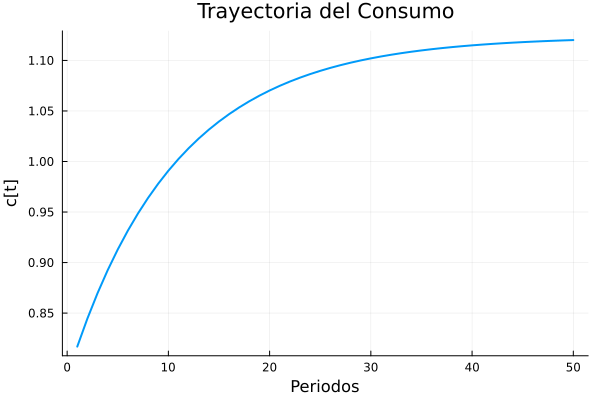

In [15]:
TG = 50
plot(c[1:TG], title = "Trayectoria del Consumo", legend = false,
     xlabel = "Periodos", ylabel = "c[t]", linewidth = 2)


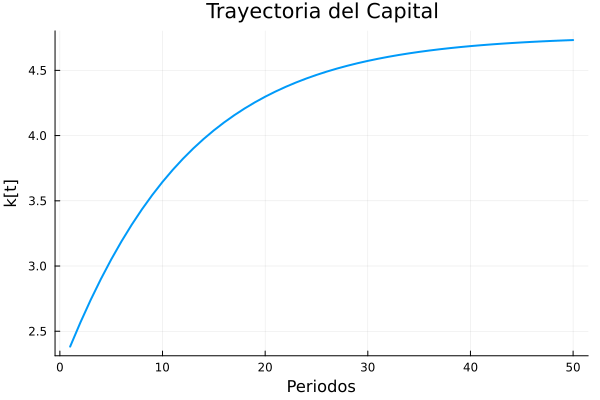

In [16]:
plot(k[1:TG], title = "Trayectoria del Capital", legend = false,
     xlabel = "Periodos", ylabel = "k[t]", linewidth = 2)

## Crecimiento del PIB Per Cápita
Analizamos el proceso de transición del crecimiento del PIB per cápita hacia su senda de crecimiento balanceado.

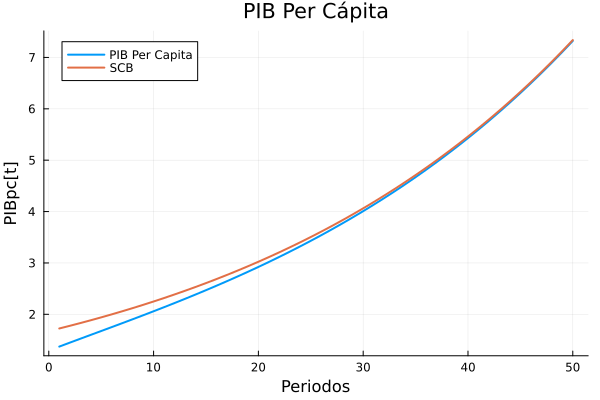

In [18]:
per = 1:length(k)
y = k.^α
ystar = kstar.^α
ypc = y.*gA.^per
ypc_star = ystar.*gA.^per

plot(per[1:TG],[ypc[1:TG] ypc_star[1:TG]], title = "PIB Per Cápita",
     xlabel = "Periodos", ylabel = "PIBpc[t]", label = ["PIB Per Capita" "SCB"],
     linewidth = 2)

#savefig("Pbipc.png")

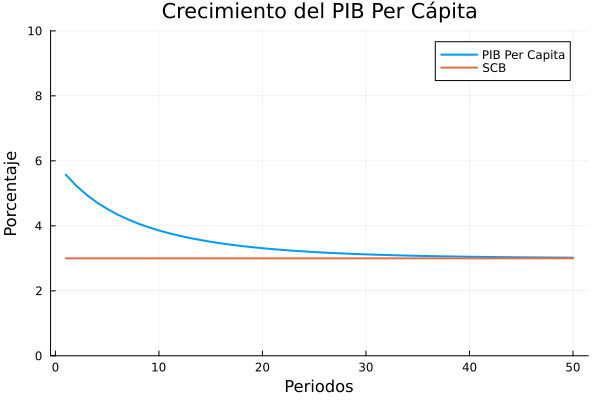

In [19]:
Δypc = ((ypc[2:end]./ypc[1:end-1]).-1)*100
Δypc_star = ((ypc_star[2:end]./ypc_star[1:end-1]).-1)*100

plot(per[1:TG],[Δypc[1:TG] Δypc_star[1:TG]], title = "Crecimiento del PIB Per Cápita",
     xlabel = "Periodos", ylabel = "Porcentaje", label = ["PIB Per Capita" "SCB"],
    linewidth = 2, ylim = (0,10))
#savefig("crec_pbipc.png")

## Con la reforma tributaria (subida de impuestos)

El cambio de impuestos es de:

$\tau^y = 0.08 , \tau^c = 0.03$

hacia

$\tau^y = 0.10 , \tau^c = 0.05$

In [20]:
# Parámetros
α = 0.33
β = 0.98
σ = 1.5
δ = 0.04
tauY1 = 0.10
tauC1 = 0.05
gA = 1 + 0.03
gL = 1 + 0.01
paramms = (α, β, σ, δ, tauY1, tauC1, gA, gL);

In [21]:
# Hallamos el estado estacionario del modelo
# F(x, params) =0 x=(x1,x2) vector
function sistema_ee1(x1,p1)
    α, β, σ, δ, tauY1, tauC1, gA, gL = p1
        
    k1 = x1[1]
    c1 = x1[2]
    
    fee1 = zeros(2)
    
    fee1[1] = 1 - β*(gA^(-σ))*(α*(1-tauY1)*k1^(α-1)+1-δ)
    fee1[2] = (1-tauY1)*(k1^α) + (1-δ-gA*gL)*k1 - c1*(1+tauC1)
    
    return fee1
end

sistema_ee1 (generic function with 1 method)

In [24]:
solucion_ee1 = nlsolve(x1 -> sistema_ee1(x1,paramms), [0.1, 0.2], inplace = false)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, 0.2]
 * Zero: [4.610597770719848, 1.0667607995754427]
 * Inf-norm of residuals: 0.000000
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 10
 * Jacobian Calls (df/dx): 10

In [25]:
kstar1 = solucion_ee1.zero[1]
cstar1 = solucion_ee1.zero[2]

println("Solución Numérica")
println("k^*=$kstar1") 
println("c^*=$cstar1")

Solución Numérica
k^*=4.610597770719848
c^*=1.0667607995754427


In [26]:
# Verificamos la solución hallada con NLsolve:

kstar22 =  ((α*β*(gA^(-σ))*(1-tauY1))/(1-β*(gA^(-σ))*(1-δ)))^(1/(1-α))
cstar22 = ((1-tauY1)*kstar22^α + (1-δ-gA*gL)*kstar22)/(1+tauC1)

println("Solución Algebraica")
println("k^*=$kstar22") 
println("c^*=$cstar22")

Solución Algebraica
k^*=4.610597772148147
c^*=1.0667607995531


In [28]:
#calculo del producto en estado estacionario
ystar = kstar1.^α

1.6559220449798844

In [29]:
println("k^*1=$kstar1")

k^*1=4.610597770719848


## Dinamica de transición 1Dinamica de transición 1

In [30]:
# Estado Inicial
k01 = kstar
println("k01=$k01") 

# Conjetura inicial para el consumo
cL1 = 0.000001*cstar1
cH1 = ((1-tauY1)*(kstar1^α) + (1-δ)*kstar1)/(1+tauC1)

# Parámetros del método de solución
T = 100
tol = 1e-4
step = 0.1
niter = 200;
flag = 0;

k01=4.764353517837232


In [31]:
k1 = zeros(T)
c1 = zeros(T)

for i in 1:niter

    c01   = (cL1+cH1)/2
    c1[1] = c01
    #println([cL1, c01, cH1])
    k1[1] = k01
    
    for t in 1:T-1
        
        k1[t+1] = ((1-tauY1)*k1[t]^α + (1-δ)*k1[t] - (1+tauC1)*c1[t])/(gA*gL)
        
        if k1[t+1]<0
            flag = 1  # Consumo inicial muy alto
            break
        elseif k1[t+1]>((1-tauY1)*(kstar1^α) + (1-δ)*kstar1)/(1+tauC1)
            flag = 2  # Consumo inicial muy bajo
            break
        else
            c1[t+1] = (β*(gA^(-σ))*(c1[t]^σ)*(α*(1-tauY1)*(k1[t+1]^(α-1)) + 1 - δ))^(1/σ)
        end
        
        if t == T-1
            if abs(k1[T]-kstar1)/kstar1 < tol && abs(c1[T]-cstar1)/cstar1 < tol
                flag = 10
            elseif k1[T]-kstar1 < -tol
                flag = 1 # Consumo inicial muy alto
            elseif k1[T]-kstar1 > tol
                flag = 2 # Consumo inicial muy bajo
            end
        end
        
    end             
        
    if flag == 1
        cH1 = copy(c01) # Eliminamos la parte alta del intervalo
    elseif flag == 2
        cL1 = copy(c01) # Eliminamos la parte bajo del intervalo
    elseif flag == 10
        println("Solución encontrada!")
        println("El consumo inicial es: $c01")
        break
    end
        
end

Solución encontrada!
El consumo inicial es: 1.0835730822559562


### trayectoria del consumo

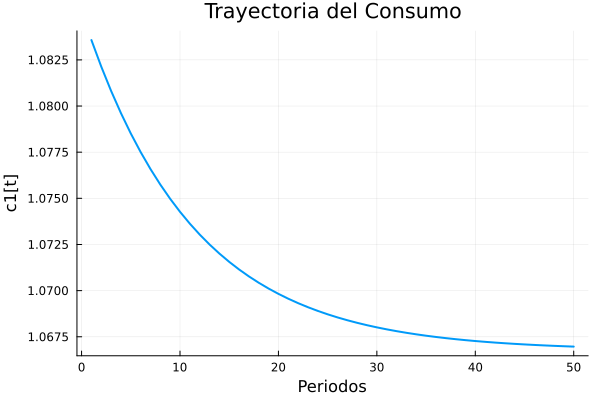

In [32]:
TG = 50
plot(c1[1:TG], title = "Trayectoria del Consumo", legend = false,
     xlabel = "Periodos", ylabel = "c1[t]", linewidth = 2)
#savefig("tra_con.png")

### trayectoria del capital

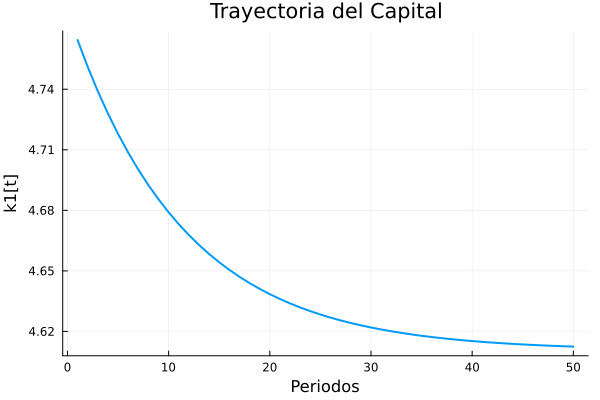

In [33]:
plot(k1[1:TG], title = "Trayectoria del Capital", legend = false,
     xlabel = "Periodos", ylabel = "k1[t]", linewidth = 2)
#savefig("tray_cap.png")

### Crecimiento del PIB Per Cápita
Analizamos el proceso de transición del crecimiento del PIB per cápita hacia su senda de crecimiento balanceado.

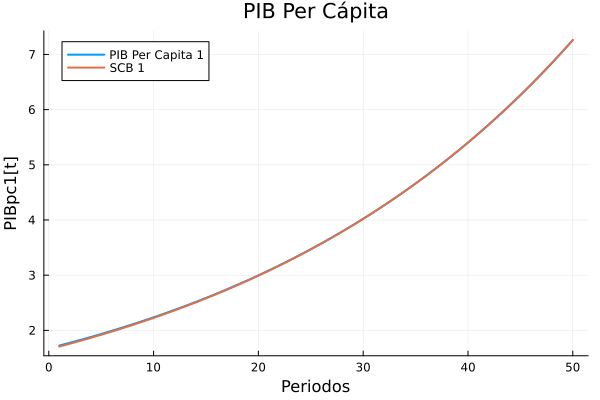

In [34]:
per1 = 1:length(k1)
y1 = k1.^α
ystar1 = kstar1.^α
ypc1 = y1.*gA.^per1
ypc_star1 = ystar1.*gA.^per1

plot(per1[1:TG],[ypc1[1:TG] ypc_star1[1:TG]], title = "PIB Per Cápita",
     xlabel = "Periodos", ylabel = "PIBpc1[t]", label = ["PIB Per Capita 1" "SCB 1"],
     linewidth = 2)
#savefig("pbipc1.png")

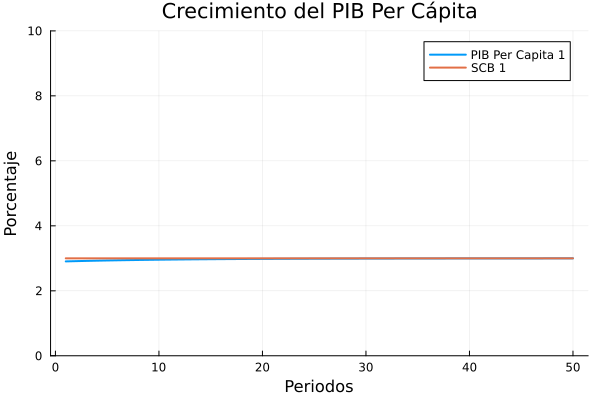

In [35]:
Δypc1 = ((ypc1[2:end]./ypc1[1:end-1]).-1)*100
Δypc_star1 = ((ypc_star1[2:end]./ypc_star1[1:end-1]).-1)*100

plot(per1[1:TG],[Δypc1[1:TG] Δypc_star1[1:TG]], title = "Crecimiento del PIB Per Cápita",
     xlabel = "Periodos", ylabel = "Porcentaje", label = ["PIB Per Capita 1" "SCB 1"],
    linewidth = 2, ylim = (0,10))
#savefig("tcpbipc1.png")

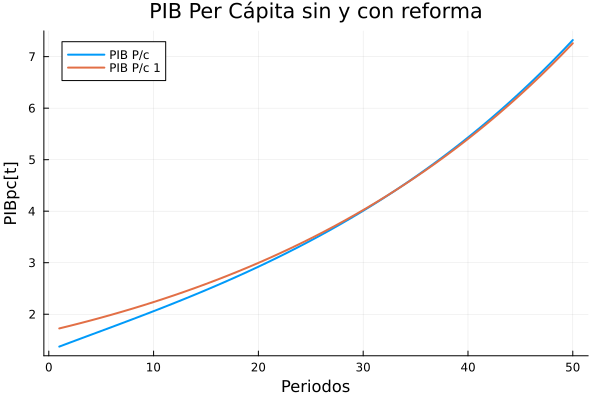

In [36]:
plot(per1[1:TG],[ypc[1:TG] ypc1[1:TG]], title = "PIB Per Cápita sin y con reforma",
     xlabel = "Periodos", ylabel = "PIBpc[t]", label = ["PIB P/c " "PIB P/c 1"],
     linewidth = 2)
#savefig("comp_pbipc.png")

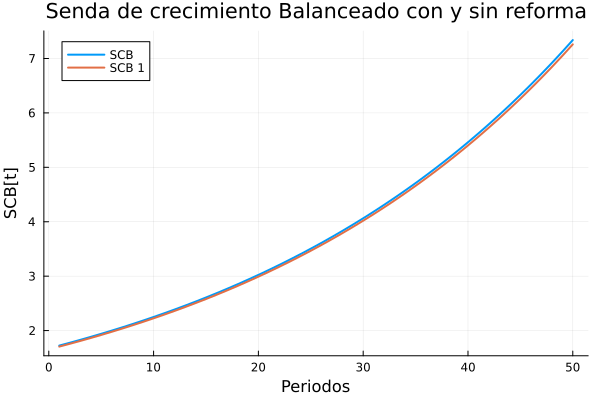

In [37]:
plot(per1[1:TG],[ypc_star[1:TG] ypc_star1[1:TG]], title = "Senda de crecimiento Balanceado con y sin reforma",
     xlabel = "Periodos", ylabel = "SCB[t]", label = ["SCB " "SCB 1"],
     linewidth = 2)
#savefig("comp_scb.png")